In [0]:
!pip install tf-nightly --quiet

     |████████████████████████████████| 520.8MB 33kB/s 
     |████████████████████████████████| 460kB 60.9MB/s 
     |████████████████████████████████| 2.9MB 54.3MB/s 


In [0]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  53.5M      0  0:00:14  0:00:14 --:--:-- 25.7M


In [0]:
!unzip --q kagglecatsanddogs_3367a.zip

## Setup

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np

tf.__version__

'2.2.0-dev20200503'

## Delete the unreadable images

Since we are working with JPEG files, if the image doesn't have a JFIF encoding, we can say that it's bad encoded.

In [0]:
import os

n = 0
for folder in ('Cat', 'Dog'):
  folder_path = os.path.join('PetImages', folder)
  for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    file_obj = open(file_path, 'rb')
    if b"JFIF" not in file_obj.peek(10):
      os.system('rm ' + file_path)
      n += 1
print(f'Deleted {n} images')

Deleted 1590 images


## Prepare the dataset

Set constant image and batch size

In [0]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory('PetImages', image_size = image_size, batch_size = batch_size,
                                                               seed = 2009, validation_split = .2, subset = 'training')
valid_ds = tf.keras.preprocessing.image_dataset_from_directory('PetImages', image_size = image_size, batch_size = batch_size,
                                                               seed = 2009, validation_split = .2, subset = 'validation')

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


## Show a sample of images


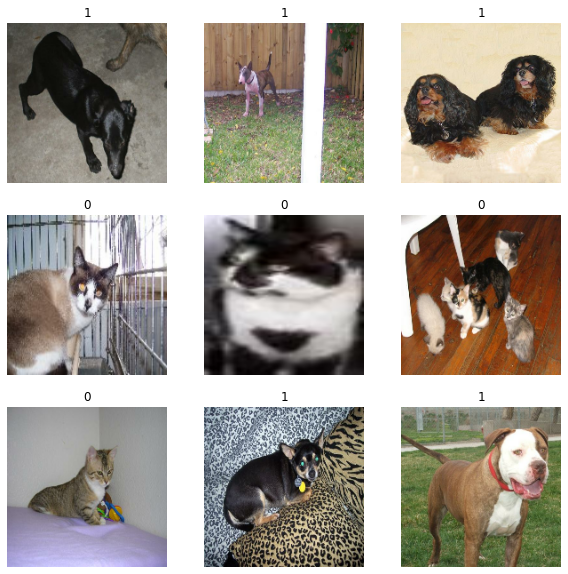

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for images,labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(labels[i].numpy())
    plt.axis('off')


## Data augmention

In [0]:
data_augmentation = keras.models.Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.RandomRotation(0.1),
])

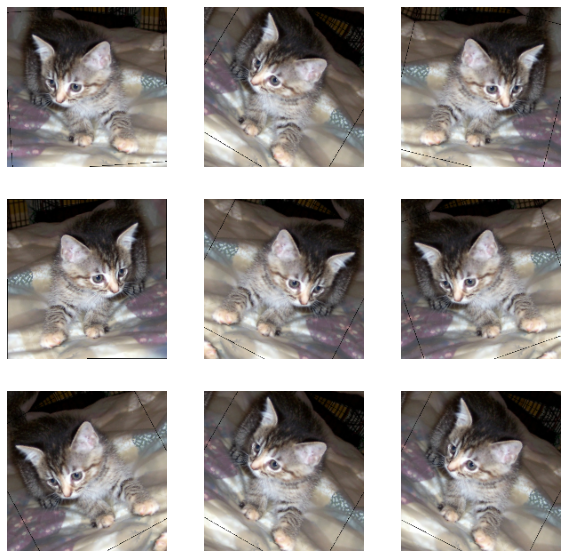

In [0]:
plt.figure(figsize=(10,10))

for images,labels in train_ds.take(1):
  for i in range(9):
    augmented_img = data_augmentation(images)
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_img[0].numpy().astype('uint8'))
    plt.axis('off')

In [0]:
train_ds = train_ds.prefetch(buffer_size = 32)
valid_ds = valid_ds.prefetch(buffer_size = 32)

## Create the model

We are creating a smaller version of Xception network


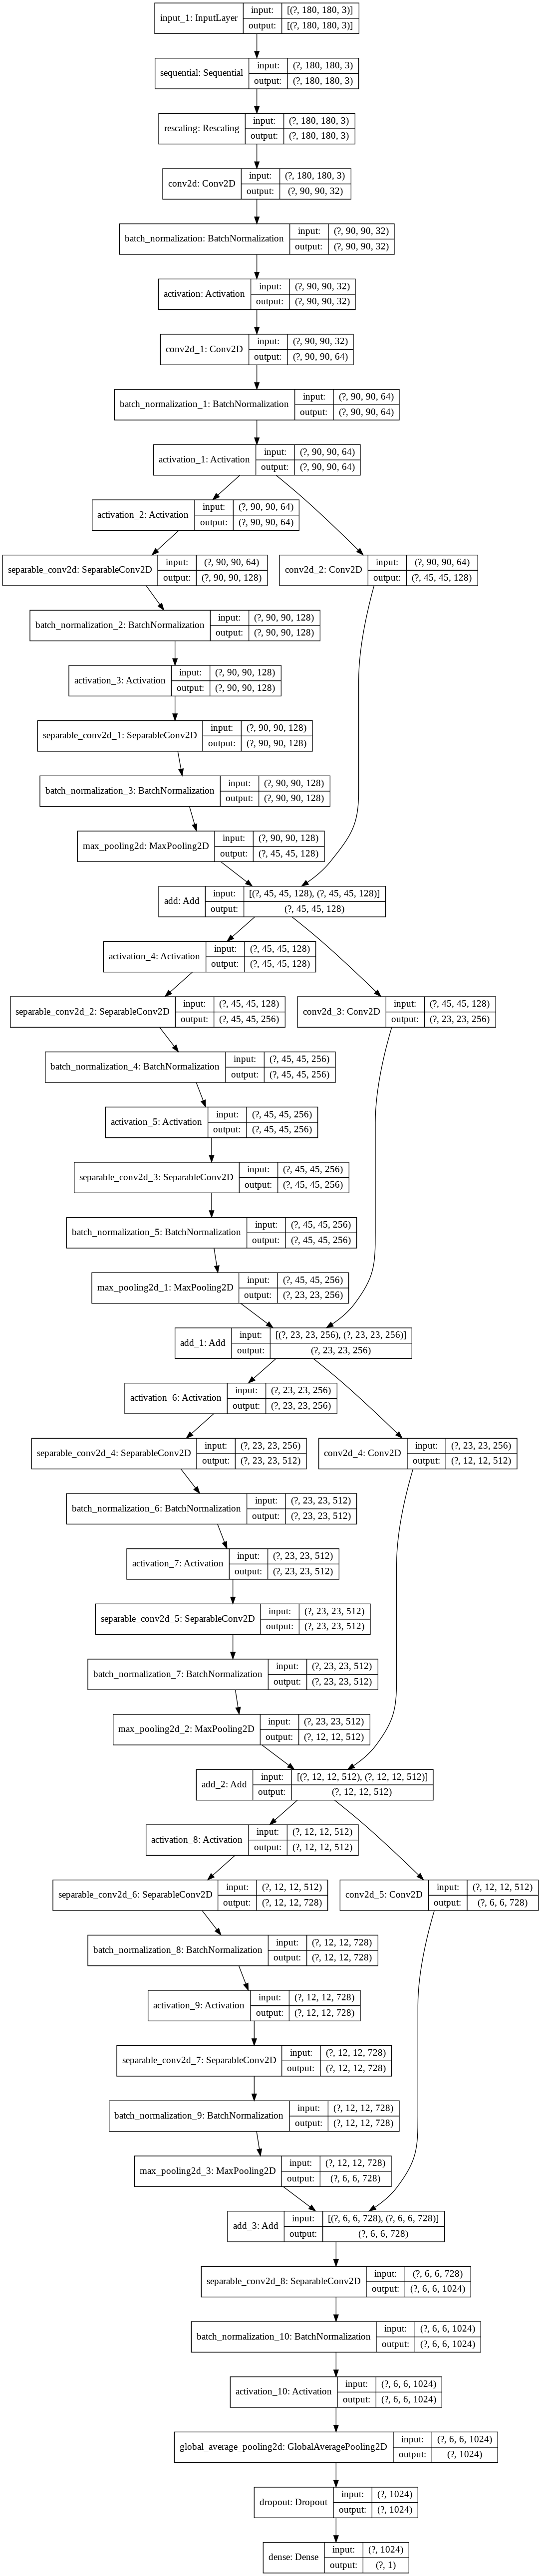

In [0]:
def make_model(input_shape, num_classes):
  inputs = layers.Input(shape = input_shape)
  # apply data augmentation
  # this is a better practice for full work-flows
  x = data_augmentation(inputs)


  # Entry block
  # Rescale the pixel values from [0,255] to [0,1]
  x = layers.experimental.preprocessing.Rescaling(1./255)(x)
  x = layers.Conv2D(32, 3, strides = 2,padding = 'same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(64, 3,padding = 'same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x

  for size in [128, 256, 512, 728]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding = 'same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding = 'same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides = 2, padding = 'same')(x)

    # Project residual
    residual = layers.Conv2D(
        size, 1, strides = 2, padding = 'same')(previous_block_activation)
    x = layers.add([x, residual]) # Add the residual back
    previous_block_activation = x

  x = layers.SeparableConv2D(1024, 3, padding = 'same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
    activation = 'sigmoid'
    units = 1
  else:
    activation = 'softmax'
    units = num_classes

  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units, activation = activation)(x)
  return keras.Model(inputs = inputs, outputs = outputs)

model = make_model(input_shape = image_size + (3,), num_classes = 2)
keras.utils.plot_model(model, show_shapes = True)

## Train the model


In [0]:
epochs = 50

callbacks = [
  keras.callbacks.ModelCheckpoint('saved_at_{epoch}.h5'),
]

model.compile(optimizer = keras.optimizers.Adam(1e-3),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

r = model.fit(train_ds, epochs = epochs, callbacks = callbacks, validation_data = valid_ds)

Epoch 1/50
586/586 [==============================] - 115s 196ms/step - loss: 0.6078 - accuracy: 0.6846 - val_loss: 0.7035 - val_accuracy: 0.6145
Epoch 2/50
586/586 [==============================] - 114s 194ms/step - loss: 0.4632 - accuracy: 0.7829 - val_loss: 0.4574 - val_accuracy: 0.7969
Epoch 3/50
586/586 [==============================] - 113s 193ms/step - loss: 0.3780 - accuracy: 0.8347 - val_loss: 0.5084 - val_accuracy: 0.7717
Epoch 4/50
586/586 [==============================] - 113s 193ms/step - loss: 0.3198 - accuracy: 0.8642 - val_loss: 0.5020 - val_accuracy: 0.7772
Epoch 5/50
586/586 [==============================] - 113s 193ms/step - loss: 0.2734 - accuracy: 0.8848 - val_loss: 0.2662 - val_accuracy: 0.8879
Epoch 6/50
586/586 [==============================] - 113s 193ms/step - loss: 0.2512 - accuracy: 0.8975 - val_loss: 0.3689 - val_accuracy: 0.8390
Epoch 7/50
586/586 [==============================] - 113s 193ms/step - loss: 0.2142 - accuracy: 0.9092 - val_loss: 0.1965 -